In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/raifha/clients_last_2_fixed.csv
/kaggle/input/raifha/client_cat_raif.csv
/kaggle/input/pyatera/Pyaterochka_transactions_.csv
/kaggle/input/fixprice-raifhack/FixPrice_transactions.csv


In [60]:
data = pd.read_csv('../input/fixprice-raifhack/FixPrice_transactions.csv', encoding = 'cp1251', sep=';', parse_dates=['purchdate'])

In [61]:
data

,purchdate,amount,mcc,mrchcity,mrchname,cnum
0,2019-09-23,20582.0,5311,TEMRYUK,94NWJ4I1 B6F5,ELHHAC
1,2019-10-23,14460.0,5311,KRASNODAR,94NWJ4I1 QPGS,ELHHAC
2,2019-10-08,12889.7,5311,TULA,94NWJ4I1 B6MF,EEI105
3,2019-10-11,11981.0,5311,KOLCZOVO,94NWJ4I1 5GPM,EL97DD
4,2019-11-30,11781.0,5311,YASNOGORSK,94NWJ4I1 QBPQ,ELEL21
...,...,...,...,...,...,...
567237,2019-10-07,1.0,5411,MOSCOW,94NWJ4I1 QVVP,QSFYCG
567238,2019-09-26,1.0,5411,MOSCOW,94NWJ4I1 QVVP,QSFYCG
567239,2019-10-08,1.0,5311,CHELYABINSK,94NWJ4I1 B56P,EE7QTC
567240,2019-12-03,1.0,5411,MOSCOW,94NWJ4I1 QVVP,ZXFNNG


In [62]:
client_cats = pd.read_csv('../input/raifha/client_cat_raif.csv', encoding = 'cp1251', sep=';')

In [63]:
clients = pd.read_csv('../input/raifha/clients_last_2_fixed.csv', encoding = 'cp1251', sep=';')
clients = clients.rename(columns={"categorycode":"category", "cnum_":"cnum"}).copy()

Сводим в одну таблицу

In [64]:
clients = pd.merge(clients, client_cats, how='inner', on = "category")

In [65]:
data1 = pd.merge(clients, data, how='inner', on = 'cnum')

# Feature Engineering

In [66]:
# фичи можно добавить только с purchdate и amount
# purchdate -> days_since_first_order(recency), days_since_last_order, frequency
# amount -> overall_amount(Monetary), order_sum, avg_amount_in_3_last_trans
# 
# мы можем прогнозозировать не только отток, но и уход к конкуренту
# 
# for i in data1.cnum.unique():
    

К каждой строке добавим дату первого заказа для каждого клиента

In [67]:
data1 = pd.merge(data1, data1.sort_values(['purchdate']).groupby('cnum').head(1).loc[:, ["purchdate", 'cnum']].rename(columns={"purchdate":"first_trans"}), on='cnum',
         how='left')

# Recency

In [68]:
data1['days_since_first_order'] = (data1.purchdate - data1.first_trans)

In [69]:
tmp = data1.drop_duplicates(subset=['cnum','purchdate']).sort_values(['purchdate'])[['cnum', 'purchdate', 'amount']]

In [70]:
tmp['days_since_last_order']  = tmp.groupby('cnum')['purchdate'].diff().apply(lambda x: x.days)

In [71]:
tmp = tmp[['cnum', 'purchdate', 'days_since_last_order']]

In [72]:
tmp.dropna(subset=['days_since_last_order'], inplace=True)

In [73]:
tmp['order_sum'] = 1
tmp.order_sum = tmp.groupby(['cnum']).order_sum.cumsum()

In [74]:
df = pd.merge(data1, 
         tmp,
         on=['cnum','purchdate'],
         how='left'
)


проверка таргета

In [75]:
df[df.cnum == 'EEPLLD'].sort_values("purchdate").head(50)

,cnum,category,gender,age,married_,residenttype,description,purchdate,amount,mcc,mrchcity,mrchname,first_trans,days_since_first_order,days_since_last_order,order_sum
63323,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-14,34.0,5311,POLEVSKOJ,94NWJ4I1 B5G6,2019-10-14,0 days,NaN,NaN
63317,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-15,34.0,5311,REVDA,94NWJ4I1 BGPS,2019-10-14,1 days,1.0,1.0
63324,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-21,34.0,5311,EKATERINBURG,94NWJ4I1 QMPP,2019-10-14,7 days,6.0,2.0
63328,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-29,27.5,5311,POLEVSKOJ,94NWJ4I1 B5G6,2019-10-14,15 days,8.0,3.0
63327,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-29,27.5,5311,POLEVSKOJ,94NWJ4I1 B5G6,2019-10-14,15 days,8.0,3.0
63320,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-10-30,34.0,5311,EKATERINBURG,94NWJ4I1 5FQS,2019-10-14,16 days,1.0,4.0
63326,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-11-01,27.5,5311,EKATERINBURG,94NWJ4I1 Q5VV,2019-10-14,18 days,2.0,5.0
63311,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-11-02,55.0,5311,PERVOURALSK,94NWJ4I1 BBGV,2019-10-14,19 days,1.0,6.0
63310,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-11-04,55.0,5311,REVDA,94NWJ4I1 BQVM,2019-10-14,21 days,2.0,7.0
63308,EEPLLD,70,M,30,married,R,Regular retail banking customer,2019-11-05,82.5,5311,POLEVSKOJ,94NWJ4I1 B5G6,2019-10-14,22 days,1.0,8.0


Модель оттока

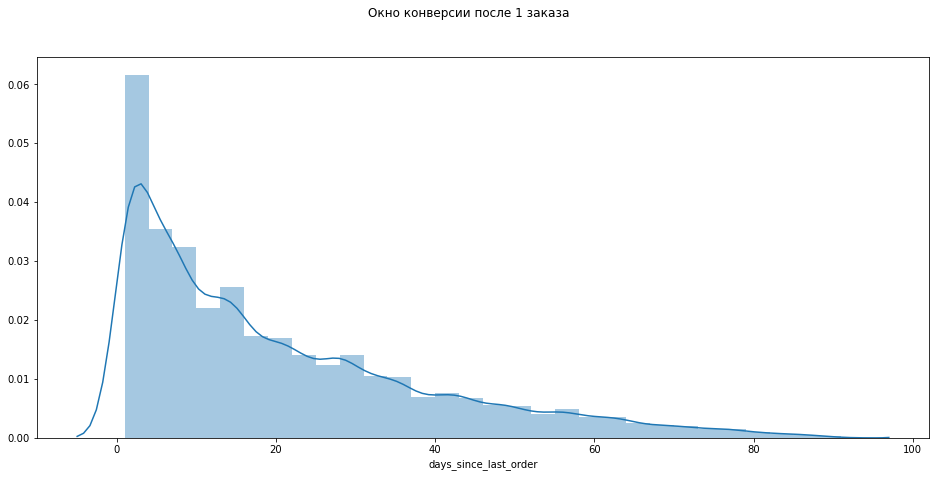

In [76]:
f, ax = plt.subplots(1, figsize=(16, 7))
f.suptitle('Окно конверсии после 1 заказа')
sns.distplot(df.query("order_sum == 1").days_since_last_order, bins=30, ax=ax)

In [77]:
np.percentile(df.query("order_sum == 1").days_since_last_order, 95)

60.0

Будем считать, что если клиент не делает второй заказ уже 60 дней, то он скорее всего его и не сделает.

In [78]:
np.percentile(df.query("order_sum > 1").days_since_last_order, 95)

30.0

Если у человека уже не первый заказ, то в худшем случае окно конверсии 30 дней. Будем считать, что клиент ушёл, если он не делает заказ уже 30 дней. Удаляю пользователей, которые появились в бд в первые 30 дней. (Потому что считать заказы в этот период "новыми" неправильно. Будет смещение)

In [79]:
valid_users = df[df.first_trans > df.purchdate.min() + pd.DateOffset(1)].cnum.unique()

In [80]:
clients_one_order = df.groupby('cnum').days_since_first_order.max().reset_index().cnum.unique()

In [81]:
df['target_one_order'] = df.loc[df.cnum.isin(clients_one_order), 'target_one_order'] = 1


In [82]:
df.target_one_order = df.target_one_order.fillna(0)
df.days_since_last_order = df.days_since_last_order.fillna(0)

In [83]:
len(df.cnum.unique())

187497

In [84]:
# Клиенты, которые не делают заказ больше 30 дней на максимальную дату из бд не вернутся. (см EDA 2 ниже)
old_clients = (((df.purchdate.max() - df.groupby('cnum').purchdate.max()) / np.timedelta64(1, 'D')).reset_index().query("purchdate > 1")).cnum.unique()

In [85]:
len(old_clients)

187377

In [86]:
#Таргет последних трёх заказов клиента
df.loc[df[df.cnum.isin(old_clients)].groupby('cnum').tail(3).index, 'target_last_3_orders'] = 1

#Таргет последних двух заказов клиента
df.loc[df[df.cnum.isin(old_clients)].groupby('cnum').tail(2).index, 'target_last_2_orders'] = 1

#Таргет последнего заказа клиента
df.loc[df[df.cnum.isin(old_clients)].groupby('cnum').tail(1).index, 'target_last_1_orders'] = 1

In [87]:
df.fillna(value = {'target_last_3_orders': 0, 'target_last_2_orders':0,
       'target_last_1_orders':0 },  inplace=True)

In [88]:
df['days_since_first_order'] = df['days_since_first_order'] / np.timedelta64(1, 'D')

In [89]:
df

,cnum,category,gender,age,married_,residenttype,description,purchdate,amount,mcc,mrchcity,mrchname,first_trans,days_since_first_order,days_since_last_order,order_sum,target_one_order,target_last_3_orders,target_last_2_orders,target_last_1_orders
0,0DHGSG,81,M,36,married,R,Affluent Banking payroll customer,2019-12-03,500.0,5311,SANKT-PETERBU,94NWJ4I1 FFM,2019-12-03,0.0,0.0,NaN,1,1.0,1.0,1.0
1,0DSXON,81,M,49,married,R,Affluent Banking payroll customer,2019-11-28,738.0,5411,MOSCOW,94NWJ4I1 B6SP,2019-11-27,1.0,1.0,1.0,1,1.0,1.0,0.0
2,0DSXON,81,M,49,married,R,Affluent Banking payroll customer,2019-11-27,63.7,5411,MOSCOW,94NWJ4I1 B6SP,2019-11-27,0.0,0.0,NaN,1,1.0,1.0,1.0
3,0FDDCO,81,M,39,married,R,Affluent Banking payroll customer,2019-10-04,248.0,5499,KRASNOGORSK,94NWJ4I1 G6F,2019-10-04,0.0,0.0,NaN,1,0.0,0.0,0.0
4,0FDDCO,81,M,39,married,R,Affluent Banking payroll customer,2019-11-24,242.5,5499,KRASNOGORSK,94NWJ4I1 G6F,2019-10-04,51.0,1.0,3.0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567237,1DSYXD,61,F,60,married,R,RBA employees (family),2019-11-27,473.0,5311,TOLYATTI,94NWJ4I1 BQ5G,2019-11-27,0.0,0.0,NaN,1,1.0,1.0,1.0
567238,MFONDN,61,F,61,not_married,R,RBA employees (family),2019-09-28,412.5,5499,MOSCOW,94NWJ4I1 QS6S,2019-09-28,0.0,0.0,NaN,1,1.0,1.0,1.0
567239,EETOCT,30,F,27,not_married,R,Corporate customer manager/ VIP,2019-11-19,100.0,5411,MOSCOW,94NWJ4I1 BMMQ,2019-11-19,0.0,0.0,NaN,1,1.0,1.0,0.0
567240,EETOCT,30,F,27,not_married,R,Corporate customer manager/ VIP,2019-11-22,50.0,5411,MOSCOW,94NWJ4I1 BMMQ,2019-11-19,3.0,3.0,1.0,1,1.0,1.0,1.0


Откидываю последние 48 дней, потому что окно конверсии в случае не первого заказа 48 дней

In [90]:
data = df[(df.cnum.isin(valid_users)) & (df.purchdate < df.purchdate.max() - pd.DateOffset(8))]

In [91]:
data.target_last_3_orders.value_counts()

1.0    298938
0.0    216773
Name: target_last_3_orders, dtype: int64

In [92]:
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score

# Разберемся с категориальными признаками
cnum, gender, married_, residenttype, description, purchdate, mrchcity, mrchname, first_trans

In [93]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
data['gender'] = lbl.fit_transform(data['gender'].astype(str))
data['age'] = lbl.fit_transform(data['age'].astype(str))
data['mrchcity'] = lbl.fit_transform(data['mrchcity'].astype(str))
data['married_'] = lbl.fit_transform(data['married_'].astype(str))
data['cnum_uncut'] = lbl.fit_transform(data['cnum'].astype(str))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [94]:
data

,cnum,category,gender,age,married_,residenttype,description,purchdate,amount,mcc,...,mrchname,first_trans,days_since_first_order,days_since_last_order,order_sum,target_one_order,target_last_3_orders,target_last_2_orders,target_last_1_orders,cnum_uncut
0,0DHGSG,81,1,21,0,R,Affluent Banking payroll customer,2019-12-03,500.0,5311,...,94NWJ4I1 FFM,2019-12-03,0.0,0.0,NaN,1,1.0,1.0,1.0,317
1,0DSXON,81,1,34,0,R,Affluent Banking payroll customer,2019-11-28,738.0,5411,...,94NWJ4I1 B6SP,2019-11-27,1.0,1.0,1.0,1,1.0,1.0,0.0,382
2,0DSXON,81,1,34,0,R,Affluent Banking payroll customer,2019-11-27,63.7,5411,...,94NWJ4I1 B6SP,2019-11-27,0.0,0.0,NaN,1,1.0,1.0,1.0,382
3,0FDDCO,81,1,24,0,R,Affluent Banking payroll customer,2019-10-04,248.0,5499,...,94NWJ4I1 G6F,2019-10-04,0.0,0.0,NaN,1,0.0,0.0,0.0,449
4,0FDDCO,81,1,24,0,R,Affluent Banking payroll customer,2019-11-24,242.5,5499,...,94NWJ4I1 G6F,2019-10-04,51.0,1.0,3.0,1,0.0,0.0,0.0,449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567237,1DSYXD,61,0,45,0,R,RBA employees (family),2019-11-27,473.0,5311,...,94NWJ4I1 BQ5G,2019-11-27,0.0,0.0,NaN,1,1.0,1.0,1.0,2259
567238,MFONDN,61,0,46,1,R,RBA employees (family),2019-09-28,412.5,5499,...,94NWJ4I1 QS6S,2019-09-28,0.0,0.0,NaN,1,1.0,1.0,1.0,155909
567239,EETOCT,30,0,12,1,R,Corporate customer manager/ VIP,2019-11-19,100.0,5411,...,94NWJ4I1 BMMQ,2019-11-19,0.0,0.0,NaN,1,1.0,1.0,0.0,84742
567240,EETOCT,30,0,12,1,R,Corporate customer manager/ VIP,2019-11-22,50.0,5411,...,94NWJ4I1 BMMQ,2019-11-19,3.0,3.0,1.0,1,1.0,1.0,1.0,84742


In [95]:
cols_target = ['category', 'gender', 'age', 'married_', 'amount', 'mrchcity','target_last_3_orders', 'days_since_last_order', 'days_since_first_order', 'order_sum']

In [96]:
data = data[cols_target]

In [97]:
X, y = data.drop('target_last_3_orders', axis=1), data.target_last_3_orders

In [98]:
X

,category,gender,age,married_,amount,mrchcity,days_since_last_order,days_since_first_order,order_sum
0,81,1,21,0,500.0,587,0.0,0.0,NaN
1,81,1,34,0,738.0,403,1.0,1.0,1.0
2,81,1,34,0,63.7,403,0.0,0.0,NaN
3,81,1,24,0,248.0,307,0.0,0.0,NaN
4,81,1,24,0,242.5,307,1.0,51.0,3.0
...,...,...,...,...,...,...,...,...,...
567237,61,0,45,0,473.0,703,0.0,0.0,NaN
567238,61,0,46,1,412.5,403,0.0,0.0,NaN
567239,30,0,12,1,100.0,403,0.0,0.0,NaN
567240,30,0,12,1,50.0,403,3.0,3.0,1.0


In [99]:
X_train, y_train = X[:96000], y[:96000]
X_test, y_test = X[96000:], y[96000:]


In [100]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [101]:
def get_metrics(actual, predicted, prob):
  print(f"Precision: {precision_score(actual, predicted)}")
  print(f"Recall: {recall_score(actual, predicted)}")
  print(f"F1: {f1_score(actual, predicted)}")
  print(f"AUC-ROC: {roc_auc_score(actual, prob)}")

In [102]:
get_metrics(y_test, xgb.predict(X_test), xgb.predict_proba(X_test)[:,1])

Precision: 0.8027264244582654
Recall: 0.9233937009557613
F1: 0.8588423401386519
AUC-ROC: 0.8942943690469952


In [103]:
!pip install shap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [104]:
import shap

In [105]:
xgb = XGBClassifier(random_state=42)
mymodel = xgb.fit(X_train, y_train)
mybooster = mymodel.get_booster()    
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

# Shap explainer initilization
shap_ex = shap.TreeExplainer(mybooster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [106]:
shap_values = shap_ex.shap_values(X_train)

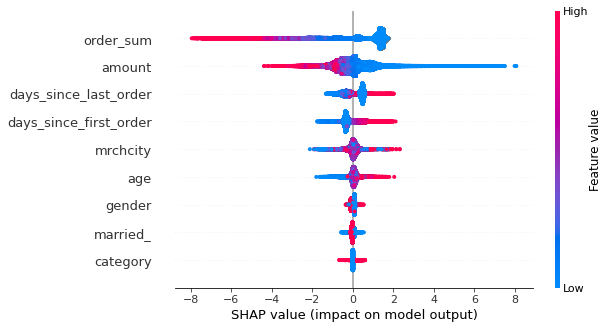

In [107]:
shap.summary_plot(shap_values, X_train)

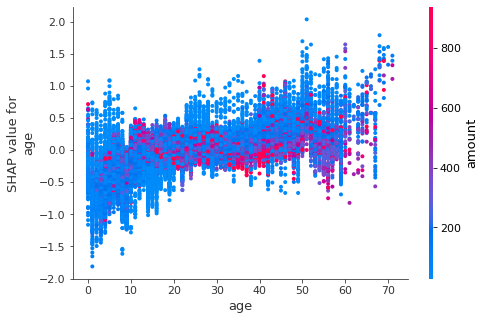

In [111]:
shap.dependence_plot('gender', shap_values, X_train, interaction_index = 'amount')

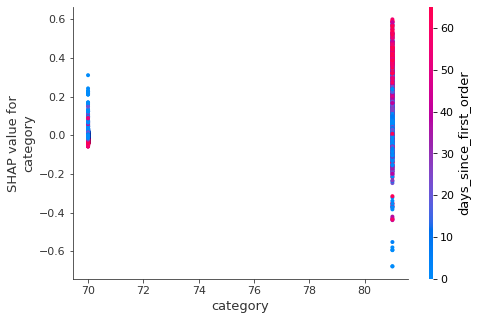

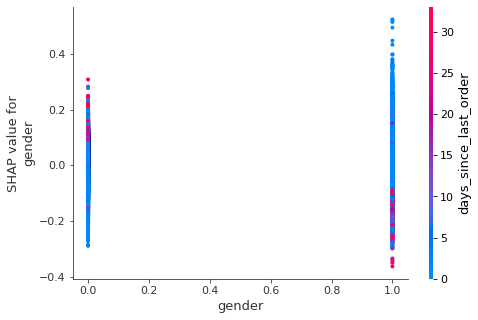

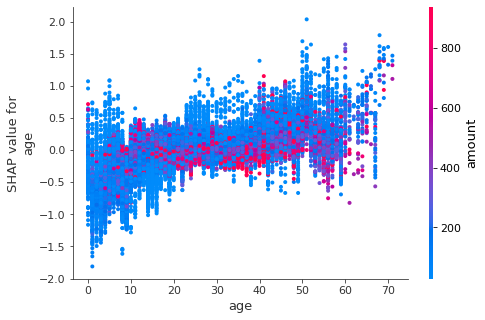

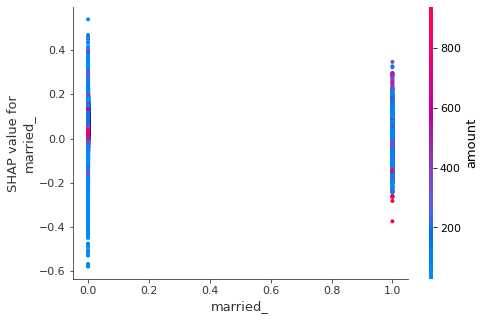

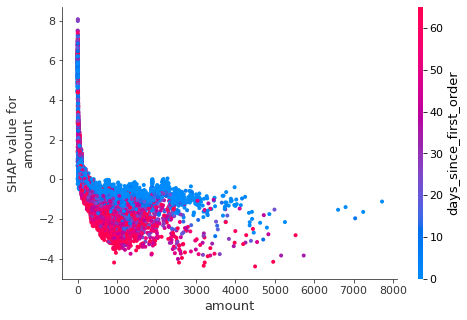

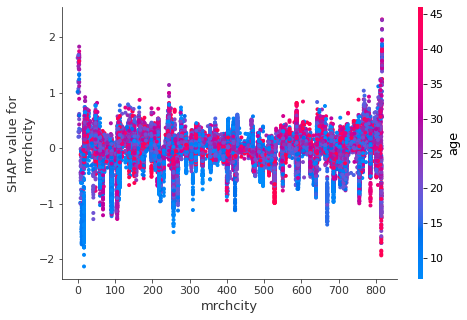

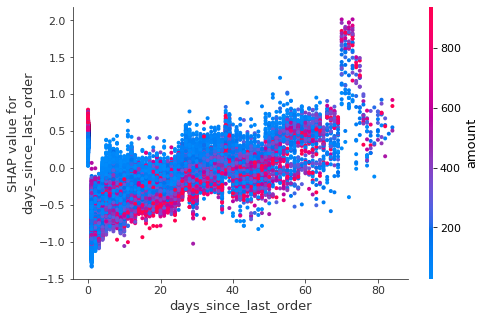

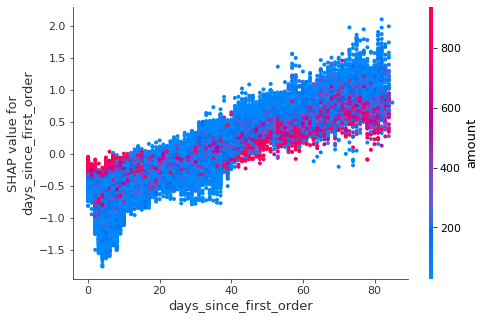

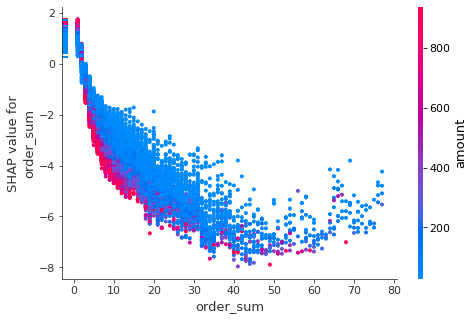

In [109]:
for col in X_train.columns:
  shap.dependence_plot(col, shap_values, X_train)

In [110]:
shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X.t)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


AttributeError: 'DataFrame' object has no attribute 't'

In [ ]:
shap.dependence_plot(
    ("age", "Sex"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)